# Full-Key Recovery

This notebook shows a **complete DL-SCA**: the full-key is recovered.

The following variables are fixed:
* ***Train Device***: D1
* ***Train Keys***: All keys, from K1 to K10
* ***Attack Configuration***: D3-K0
* ***Target***: SBOX_OUT

In order to recover the full-key, **16 models are required**, one for each byte.\
Hyperparameter Tuning has been performed **separately for each model** (empirical results showed that it is not possible to recover a byte with a model that was not previously trained to detect it).

The 16 models have been trained with traces from device D1 and all possible keys (from K1 to K10) and saved.\
The saved models are **loaded** and used to attack D3-K0.

In [1]:
# Basics
import json
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Custom
import sys
sys.path.insert(0, '../src/utils')
import helpers
import results
import constants
from data_loader import DataLoader, SplitDataLoader
sys.path.insert(0, '../src/modeling')
from network import Network

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

## Training

In [2]:
FULL_KEY_RECOVERY_FOLDER = f'{constants.RESULTS_PATH}/FullKeyRecovery'
TRAIN_FOLDER = FULL_KEY_RECOVERY_FOLDER + '/training'
SCALER_STATS_PATH = TRAIN_FOLDER + '/scaler_stats.npy'

In [3]:
if len(os.listdir(TRAIN_FOLDER)) == 0: # Models training is done only once, when models' folder is empty 
    
    scaler_stats = []

    for b in tqdm(range(16), desc='Training the 16 models: '):
        
        # Define all paths
        RES_ROOT = f'{constants.RESULTS_PATH}/DKTA/SBOX_OUT/byte{b}/1d' 
        HP_PATH = RES_ROOT + '/hp.json'
        MODEL_PATH = TRAIN_FOLDER + f'/model_b{b}.h5'
        
        
        # Get train data
        train_files = [f'{constants.PC_TRACES_PATH}/D1-{k}_500MHz + Resampled.trs' 
                       for k in list(constants.KEYS)[1:]]
        
        train_dl = SplitDataLoader(
            train_files, 
            tot_traces=50000,
            train_size=0.9,
            target='SBOX_OUT',
            byte_idx=b
        )
        train_data, val_data = train_dl.load()
        x_train, y_train, _, _ = train_data 
        x_val, y_val, _, _ = val_data

        # Scale data to 0-mean and 1-variance
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_val = scaler.transform(x_val)

        # Save scaler's stats
        mean, std = scaler.mean_, scaler.scale_
        scaler_stats.append((mean, std))
        
        
        # Get hyperparameters
        with open(HP_PATH, 'r') as jfile:
            hp = json.load(jfile)
        
        
        # Train and save the model
        net = Network('MLP', hp)
        net.build_model()
        net.add_checkpoint_callback(MODEL_PATH)\

        _ = net.model.fit(
            x_train, 
            y_train, 
            validation_data=(x_val, y_val),
            epochs=100,
            batch_size=net.hp['batch_size'],
            callbacks=net.callbacks,
            verbose=0
        )

    scaler_stats = np.array(scaler_stats)
    np.save(SCALER_STATS_PATH, scaler_stats)

## Attack

In [46]:
TEST_FILES = [f'{constants.PC_TRACES_PATH}/D3-K0_500MHz + Resampled.trs'] # list is needed in DataLoader
ATTACKED_KEY = np.array([int(kb, 16) for kb in constants.KEYS['K0']])

SINGLE_RECOVERY_FILE = FULL_KEY_RECOVERY_FOLDER + '/single_recovery.csv'

MULTI_RECOVERY_TRACES_FILE = FULL_KEY_RECOVERY_FOLDER + '/multi_recovery_traces.csv'

GES_FILE = FULL_KEY_RECOVERY_FOLDER + '/ge_per_byte.csv'
GES_PLOT_SINGLE = FULL_KEY_RECOVERY_FOLDER + '/ge_per_byte.svg'

BFB_FILE = FULL_KEY_RECOVERY_FOLDER + '/bfb.csv'
BFB_PLOT = FULL_KEY_RECOVERY_FOLDER + '/bfb.svg'

In [43]:
def full_key_recovery(guessing_entropy=False):
    
    """
    Recovers the full attack key.
    
    Parameters:
        - guessing_entropy (bool, default: False):
            Whether or not computing the Guessing Entropy of the attack.
            If False, the result is the actual key.
            If True, the result is the Guessing Entropy for each byte.
            
    Returns:
        - ret_val (np.ndarray):
            Either the predicted key or the Guessing Entropy for each byte.
    """
    
    res = []
    
    scaler_stats = np.load(SCALER_STATS_PATH)
    
    for b in range(16):
        
        MODEL_PATH = TRAIN_FOLDER + f'/model_b{b}.h5'
        
        model = load_model(MODEL_PATH)

        dl = DataLoader(
            TEST_FILES,
            tot_traces=50000,
            target='SBOX_OUT',
            byte_idx=b
        )
        x, y, pbs, tkb = dl.load()
        
        # Scale data to 0-mean and 1-variance
        mean, std = scaler_stats[b]
        x = (x - mean) / std

        preds = model.predict(x)

        if guessing_entropy:
            ge = results.ge(
                model=model,
                x_test=x, 
                pltxt_bytes=pbs, 
                true_key_byte=tkb, 
                n_exp=100, 
                target='SBOX_OUT'
            )
            res.append(ge)
        else:
            predicted_key_bytes = results.retrieve_key_byte(
                preds=preds, 
                pltxt_bytes=pbs,  
                target='SBOX_OUT'
            ) 
            predicted_key_bytes = np.array(predicted_key_bytes)
            res.append(predicted_key_bytes[:100]) # No need to consider all 50k attack traces    
      
    res = np.array(res)
        
    return res 


def plot_ges(ges, output_path, visualize_bytes=False):

    """
    Plots the provided GEs.
    
    Parameters:
        - ges (np.ndarray):
            Guessing Entropies to plot.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
        - visualize_bytes (bool, default: False):
            Whether or not group the curves per row of bytes (4 groups, based on the resul of "byte_idx mod 4").
            "Rows" refers to the AES state, a 4x4 matrix.
            Each group has its own color in the plot.
    """
    
    # Set the colors
    if visualize_bytes:
        colors = list(mcolors.TABLEAU_COLORS)[:4] # First 4 default colors
    else:
        cmap = plt.cm.jet # Google Turbo
        colors = cmap(range(0, cmap.N, int(cmap.N/len(ges))))
    
    f, ax = plt.subplots(figsize=(15,8))
    
    for i, ge in enumerate(ges):
        
        c_idx = i%4 if visualize_bytes else i
    
        ax.plot(ge, marker='o', color=colors[c_idx], label=f'Byte{i}')

        ax.set_title('GE All-Bytes')
        ax.set_xticks(range(len(ge)), labels=range(1, len(ge)+1)) 
        ax.set_xlabel('Number of traces')
        ax.set_ylabel('GE')
    
    plt.grid()
    plt.legend()
    
    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)


def plot_bfb(bfb, output_path):

    colors = list(mcolors.TABLEAU_COLORS)[:4]

    f, ax = plt.subplots(4, 4, figsize=(30, 30))

    n_traces = bfb.shape[1] 

    col = 0
    for b in range(16):
        row = b % 4
        x = [i for i in range(n_traces)]
        y = bfb[b]
        
        ax[row, col].bar(x, y, tick_label=[i+1 for i in range(n_traces)], color=colors[row])
        ax[row, col].set_ylim(0, 7)
        ax[row, col].set_title(f'Byte {b}')
        ax[row, col].set_xlabel('Number of Traces')
        ax[row, col].set_ylabel('Bits to Brute-Force')

        if row == 3:
            col += 1

    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)

## Single Full-Key Recovery

In [6]:
predicted_keys = full_key_recovery()

csv_pred_data = np.vstack(
    (
        np.arange(predicted_keys.shape[1])+1,
        predicted_keys
    )
).T
helpers.save_csv(
    data=csv_pred_data, 
    columns=['NTraces']+[f'Pred_Byte{b}' for b in range(16)],
    output_path=SINGLE_RECOVERY_FILE
)

for i, key in enumerate(predicted_keys.T): # Transpose to "see" the keys horizontally
    if np.array_equal(key, ATTACKED_KEY):
        print(f'Correct key found in {i+1} attack traces:')
        print(f'Predicted key: {" ".join(helpers.int_to_hex(key)).upper()}')
        print(f'Correct key:   {" ".join(constants.KEYS["K0"]).upper()}')
        break

Correct key found in 31 attack traces:
Predicted key: 95 30 FC D9 D6 FD 1D 9B 62 03 28 01 B6 5C 1C 28
Correct key:   95 30 FC D9 D6 FD 1D 9B 62 03 28 01 B6 5C 1C 28


## Average Number of Traces for Full-Key Recovery

In [7]:
N_EXP = 10

n_traces = []
for i in tqdm(range(N_EXP), desc='Performing multiple Full-Key Recoveries: '):
    
    predicted_keys = full_key_recovery()

    for j, key in enumerate(predicted_keys.T): # Transpose to "see" the keys horizontally
        if np.array_equal(key, ATTACKED_KEY):
            n_traces.append(j+1)
            break

n_traces = np.expand_dims(np.array(n_traces), axis=0)

Performing multiple Full-Key Recoveries: 100%|██████████| 10/10 [46:33<00:00, 279.39s/it]


In [8]:
csv_tr_data = np.vstack(
    (
        np.arange(N_EXP)+1,
        n_traces
    )
).T
helpers.save_csv(
    data=csv_tr_data, 
    columns=['Experiment', 'NTraces'],
    output_path=MULTI_RECOVERY_TRACES_FILE
)

avg_n_traces = np.mean(n_traces)

print(f'Average Number of Attack Traces for Full-Key Recovery: {avg_n_traces:.2f}')

Average Number of Attack Traces for Full-Key Recovery: 17.30


On average (100 experiments), **it is possible to recover the correct full-key in less than 20 traces**.

## All-Bytes Guessing Entropy

In [9]:
ges = full_key_recovery(guessing_entropy=True)

# Add the relative byte to each GE
ges_data = np.append(ges, np.expand_dims(range(16), axis=1), axis=1)

csv_ges_data = np.vstack(
    (
        np.arange(ges.shape[1])+1, # The values of the x-axis in the plot
        ges # The values of the y-axis in the plot
    )
).T
helpers.save_csv(
    data=csv_ges_data, 
    columns=['NTraces']+[f'Byte{b}' for b in range(ges.shape[0])],
    output_path=GES_FILE
)

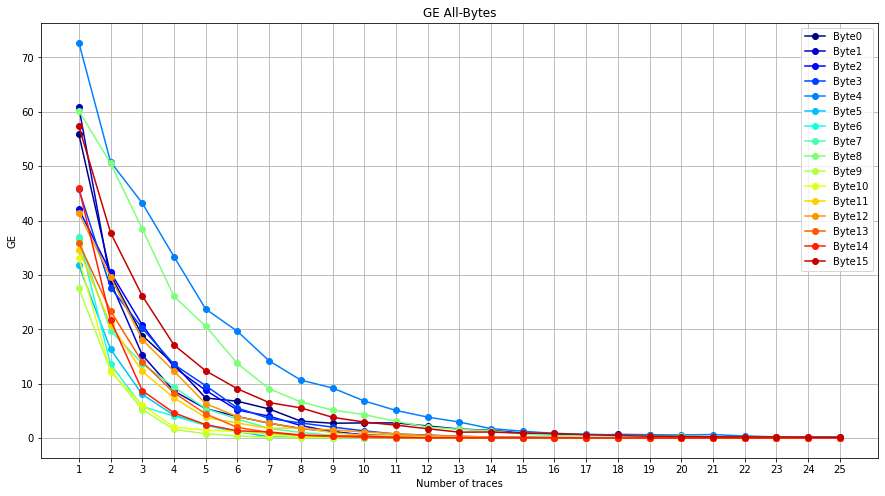

In [48]:
plottable_ges = ges[:, :25] # Plot GE of every byte, but only with max 10 traces
plot_ges(plottable_ges, GES_PLOT_SINGLE)

**There is no dependency between "difficulty" in retrieving a certain byte and the position of that byte in the AES state**.

## Brute-Force Bits Plots

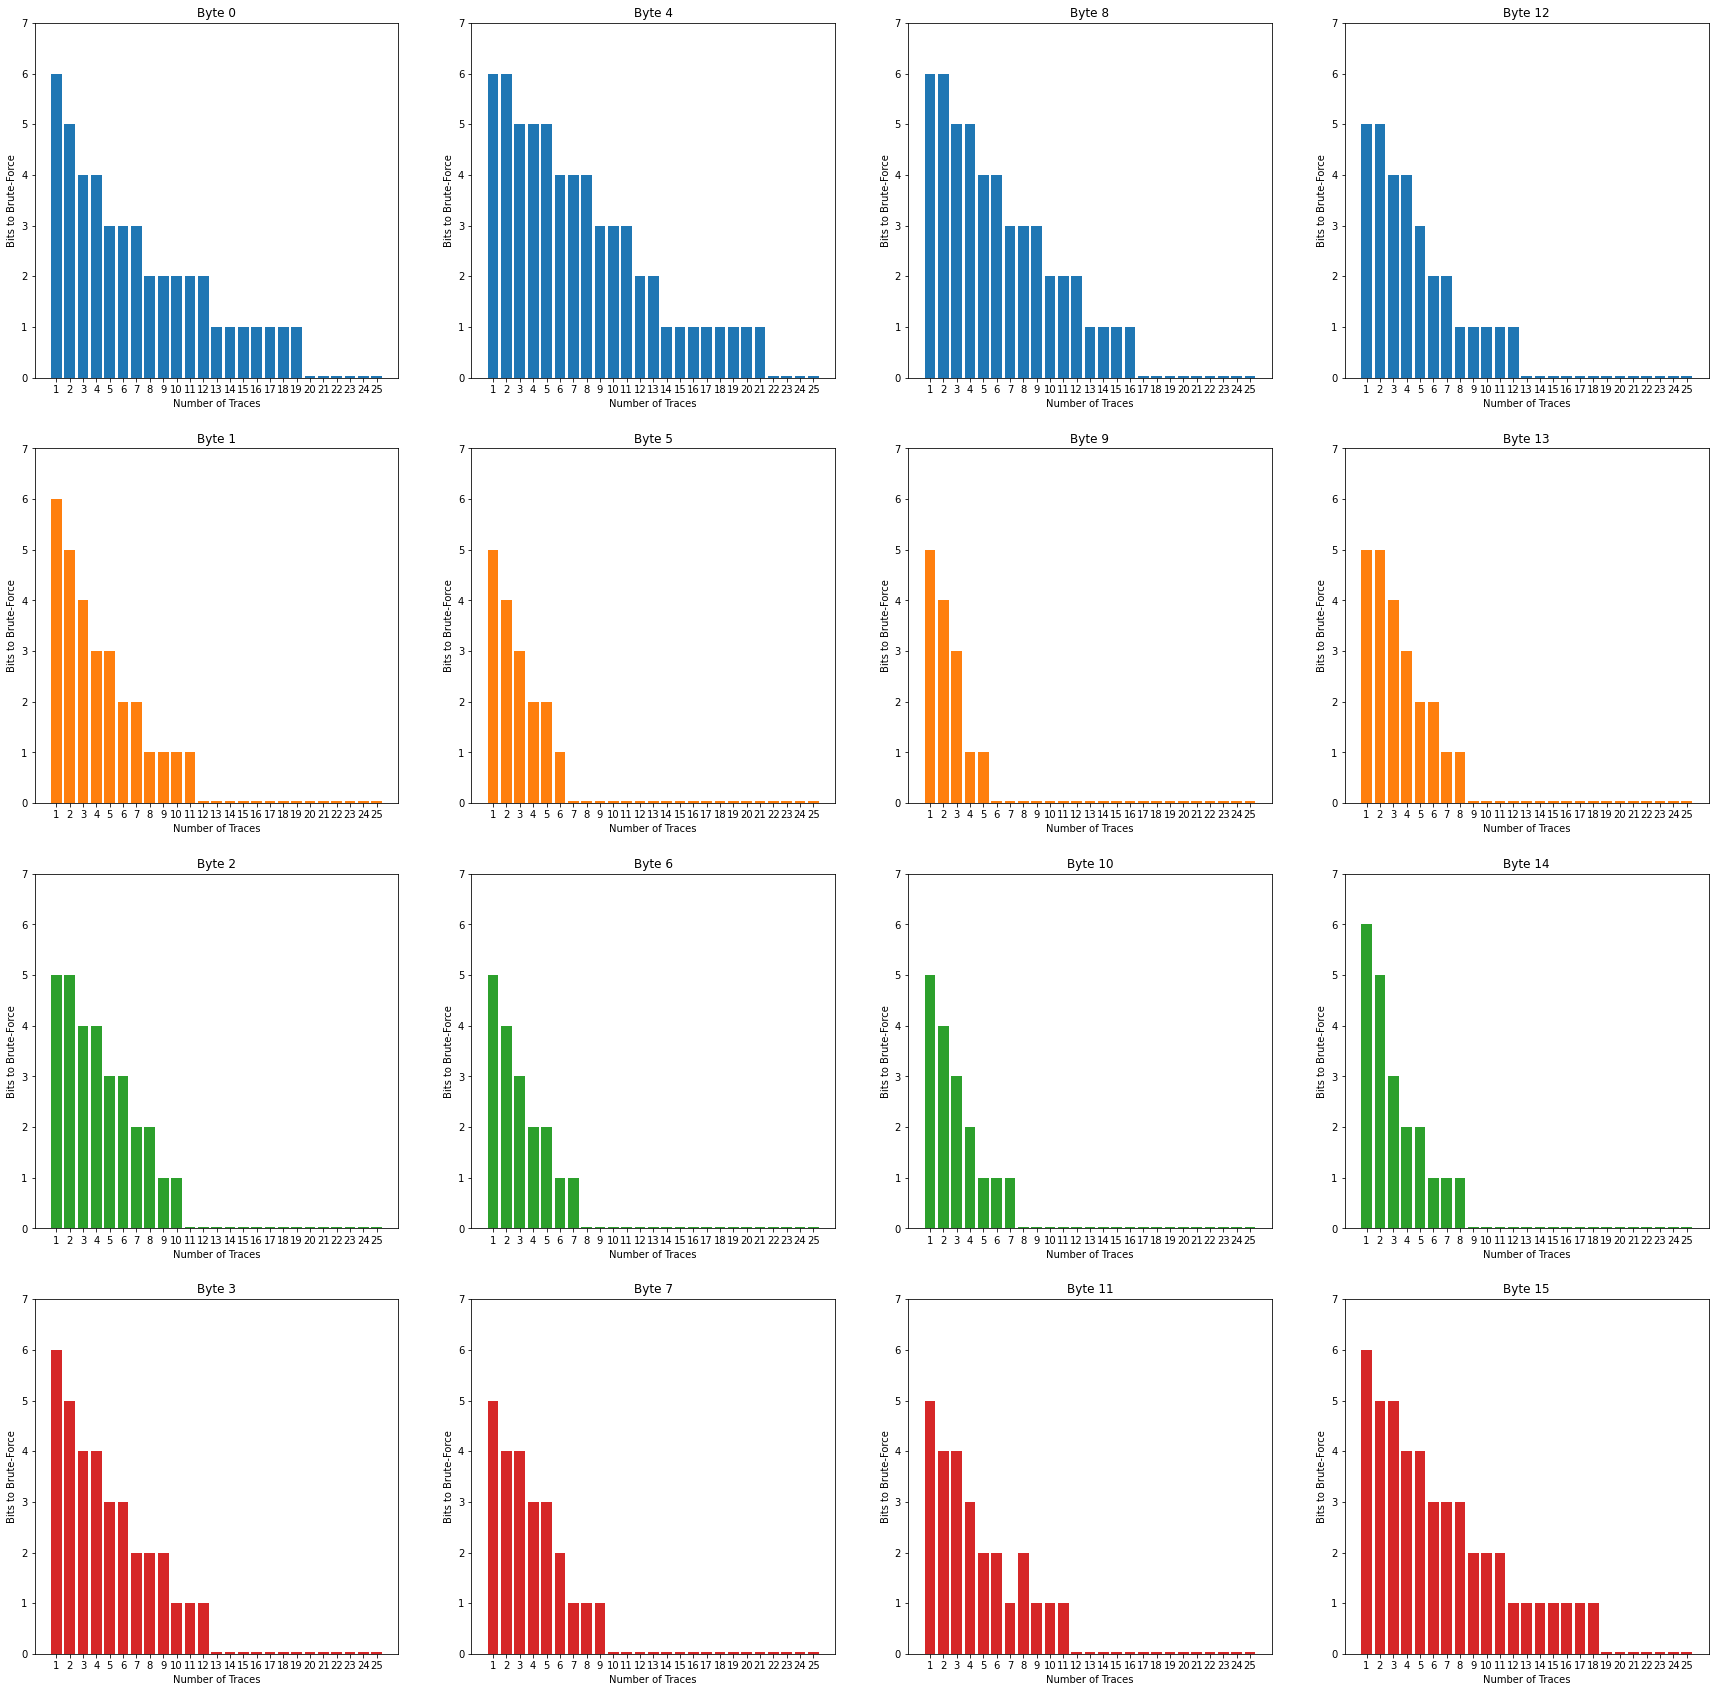

In [52]:
rounded_logs = np.rint(np.log2(plottable_ges + 1))
# rounded_logs = np.rint(np.log2(plottable_ges + 1e-22))

# Replace all negative results with 0 (to brute-force x<0 bits is meaningless)
# Idea: consider elements of rounded_logs if they are positive, otherwise put 0.03
# 0.03 is added for plotting reasons (0 is not useful in the plot)
bfb = np.where(rounded_logs > 0, rounded_logs, 0.03) # brute_force_bits

csv_bfb_data = np.vstack(
    (
        np.arange(bfb.shape[1]),
        bfb
    )
).T
helpers.save_csv(
    data=csv_bfb_data, 
    columns=['NTraces']+[f'Byte{b}' for b in range(bfb.shape[0])],
    output_path=BFB_FILE
)

plot_bfb(bfb, BFB_PLOT)